# Data Exploration

In [25]:
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
font = {'size': 18}
matplotlib.rc('font', **font)
import warnings
warnings.filterwarnings("ignore")

Importing data (see ```data-collection.ipynb```):

In [3]:
df = pd.read_pickle(r'./data/train.pkl')
df.head()

,id,author,title,selftext,time,date,score,num_comments
54442,n97ehm,weremanthing,Refinance my home to free up VA loan or wait?,First let me say thank you for looking at my p...,11:20:52,2021-05-10,1,2
41531,nzf89i,b1ackcat,Thank you for being such a great resource; you...,[removed],01:08:32,2021-06-14,1,2
61126,mxntnt,runnerup,"401k vs 457b, not sure which to max first",My work has both the 401k and 457b plans. They...,12:50:32,2021-04-24,3,7
87222,lg8t6y,Bunburier,"Student Loans, Interest Rate, and Payment Stra...",I'll be attending graduate school soon. Tuitio...,12:44:56,2021-02-09,2,2
34549,obzx08,Mxnchkinz_,What do I put under Gross Income when applying...,I'm applying for a Discover Secured Credit Car...,21:27:28,2021-07-01,0,15


## Basic Statistics

We first summarize the distribution of the data for score and comments

In [4]:
df.describe()

,score,num_comments
count,124941.000000,124941.000000
mean,19.677840,13.408457
std,250.201019,45.011245
min,0.000000,0.000000
25%,1.000000,2.000000
50%,1.000000,6.000000
75%,2.000000,12.000000
max,15778.000000,2794.000000


We observe that the mean, standard deviation, and max are higher for score than for the number of comments per post.  However the the values of each quartile are lower for score; these data imply that there is some sort of skewing occuring, but that there seems a prominent difference in skewedness occuring between the two variables.

### Distribution of ```score```

We next plot the distribution of score values

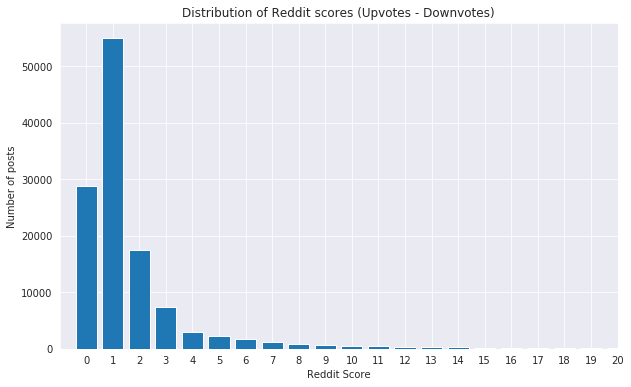

In [6]:
score_freqs = df.score.value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.bar(list(score_freqs.keys()), list(score_freqs))
plt.xlim(-1,20)
plt.xticks([i for i in range(21)])
plt.title('Distribution of Reddit scores (Upvotes - Downvotes)')
plt.xlabel('Reddit Score')
plt.ylabel('Number of posts')
plt.show()

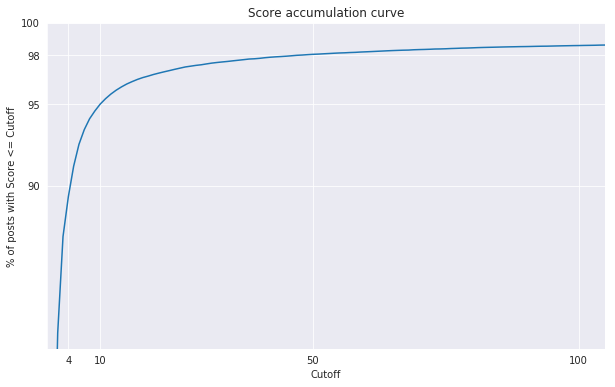

In [7]:
proportions = []
cutoffs = [i for i in range(106)]
for cutoff in cutoffs:
    proportion = sum([100*score_freqs[c] for c in score_freqs.keys() if c <= cutoff]) / sum(score_freqs)
    proportions.append(proportion)

plt.figure(figsize=(10,6))
plt.plot(cutoffs, proportions)
plt.title('Score accumulation curve')
plt.xlabel("Cutoff")
plt.ylabel("% of posts with Score <= Cutoff")
plt.xticks([4, 10, 50, 100])
plt.yticks([90, 95, 98, 100])
plt.xlim(0,105)
plt.ylim(80,100)
plt.show()

We observe the scores are highly skewed, >90% of posts have a score less than or equal to 5, and >95% less than 12, and >98% less than 50.

### Distribution of ```comment number```

As well as the distribution of comment values

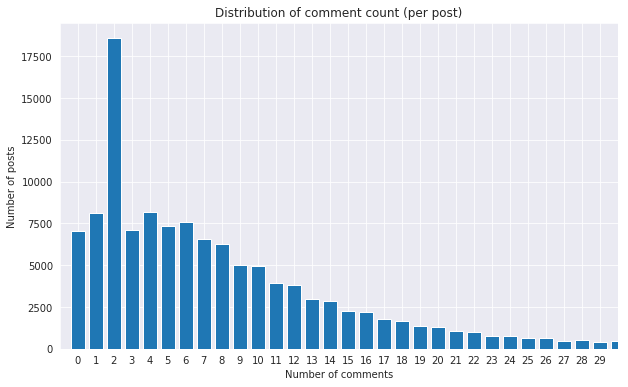

In [8]:
score_freqs = df.num_comments.value_counts().sort_index()

plt.figure(figsize=(10,6))
plt.bar(list(score_freqs.keys()), list(score_freqs))
plt.xlim(-1,30)
plt.xticks([i for i in range(30)])
plt.title('Distribution of comment count (per post)')
plt.xlabel('Number of comments')
plt.ylabel('Number of posts')
plt.show()

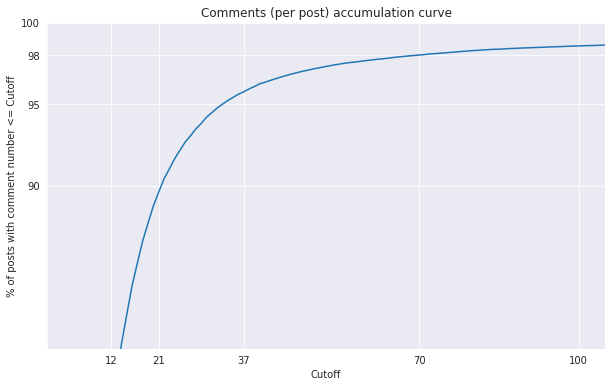

In [9]:
proportions = []
cutoffs = [i for i in range(106)]
for cutoff in cutoffs:
    proportion = sum([100*score_freqs[c] for c in score_freqs.keys() if c <= cutoff]) / sum(score_freqs)
    proportions.append(proportion)

plt.figure(figsize=(10,6))
plt.plot(cutoffs, proportions)
plt.title('Comments (per post) accumulation curve')
plt.xlabel("Cutoff")
plt.ylabel("% of posts with comment number <= Cutoff")
plt.xticks([12, 21, 37, 70, 100])
plt.yticks([90, 95, 98, 100])
plt.xlim(0,105)
plt.ylim(80,100)
plt.show()

We observe the comment number is also skewed, although less extreme, in which >90% of posts have fewer than 21, and >95% less than 37, and ~98% less than 70. After plotting the distributions directly, we find that the score data has a larger range, but is more extremely skewed toward low values.

### Relationship between score and comment count

We next begin to explore the relationship between Reddit score and comment count by plotting the two against each other

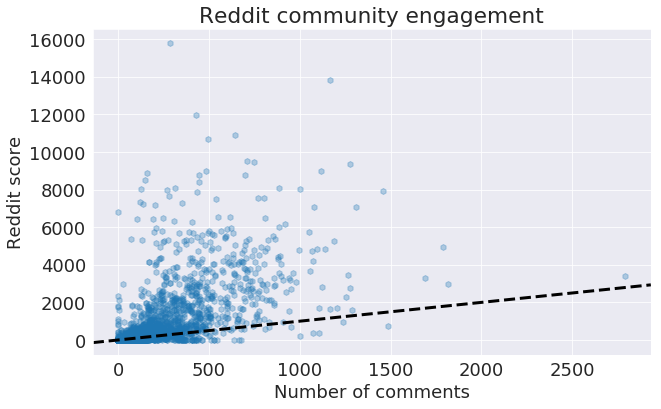

In [26]:
plt.figure(figsize=(10,6))
plt.plot(df.num_comments,
         df.score, 'h',
         alpha=0.3)
plt.xlabel('Number of comments')
plt.ylabel('Reddit score')

#add a y = x line
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

plt.title('Reddit community engagement')
plt.show()

We observe that there is a positive association between the two variables, and that the engagement can be greater than or less than 1, but has a tendency to become much greater than 1 as the number of comments increase.  The data also looks like it is in need of a transformation so we will replot using a log scale. We note that points can have high values by reddit score, number of comments, or both.

This plot points us to our primary metric.  Since points are arranged in various positions, we'll need a way to compare them objectively.  The most straightforward way to do this is to compute the euclidean distance from the origin.  We will use this quantity as our primary "virulence score". However, we can also note that depending on whether a point lies above or below the y = x line provides a second, more qualitative way, of categorizing the type of community engagement -- which may provide further resultion when we conduct our machine learning.  We will call this the "community engagement (CE) index."  We can compute this as the ratio of the reddit score to the number of comments.  This also represents the slope of the lines from the origin to that point, which we can use to compare directly to the y = x line. The CE index will help differentiate between different types of community responses, given their v-score.  But we note that there appear to be regions of clear bias; the lowest v-scores seem to be score biased, transition to a comment bias in the middle range, and then back to score bias in the region of the graph representing the highest v-scores

#### Community engagement: Virality score (v-score)

We first replot the community engagement, to assess whether a log tranformation is a good choice

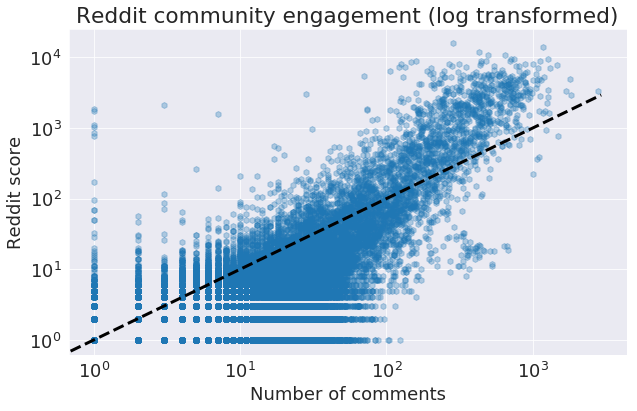

In [33]:
plt.figure(figsize=(10,6))
plt.plot(df.num_comments,
         df.score, 'h',
         alpha=0.3)
plt.xlabel('Number of comments')
plt.ylabel('Reddit score')
#add a y = x line
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
plt.xscale('log')
plt.yscale('log')
plt.title('Reddit community engagement (log transformed)')
plt.show()

These data look a lot closer to linear approximation, but there is some weird artifacts in the lower-left portion of the graph.  A further or different transformation might be necessary. Next we will calculate the distance from the origin; our Virulence score (v-score).  We calculate a raw as well as a log-transformed version.

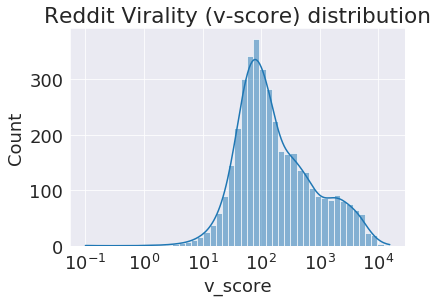

In [34]:
# Raw v-scores
Vscore = np.hypot(df.num_comments, df.score) + 0.1
Vscore_dist = Vscore.value_counts().rename_axis('v_score').reset_index(name='counts')
sns.histplot(data=Vscore_dist,
             x="v_score",
             kde=True,
             log_scale=True)
plt.title('Reddit Virality (v-score) distribution')
np.seterr(divide = 'warn') 
plt.show()

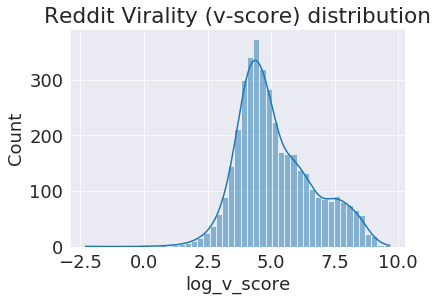

In [30]:
# log-transformed v-scores
log_Vscore = np.log(np.hypot(df.num_comments, df.score) + 0.1)
log_Vscore_dist = log_Vscore.value_counts().rename_axis('log_v_score').reset_index(name='counts')
sns.histplot(data=log_Vscore_dist,
             x="log_v_score",
             kde=True)
plt.title('Reddit Virality (v-score) distribution')
np.seterr(divide = 'warn') 
plt.show()

#### Community engagement: Qualitative index

To rate the particular quality of user engagement per post, we calculate the ratio of the reddit score to the number of comments.  This also represents the slope of the lines from the origin to that point.

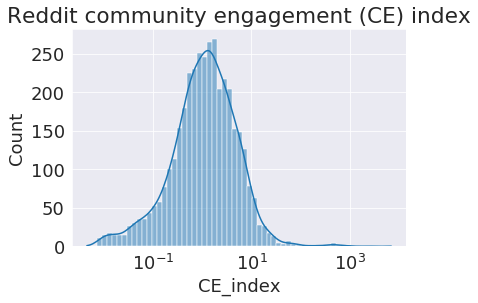

In [31]:
# Raw CE index
CE_index = ((df.score + 1) / (df.num_comments + 1))
CE_index_dist = CE_index.value_counts().rename_axis('CE_index').reset_index(name='counts')
sns.histplot(data=CE_index_dist,
             x="CE_index",
             kde=True,
             log_scale=True)
plt.title('Reddit community engagement (CE) index')
plt.show()

Again, we may want to transform the data in order to make it more tractable.  We perform a log transformation on both categories and replot the data

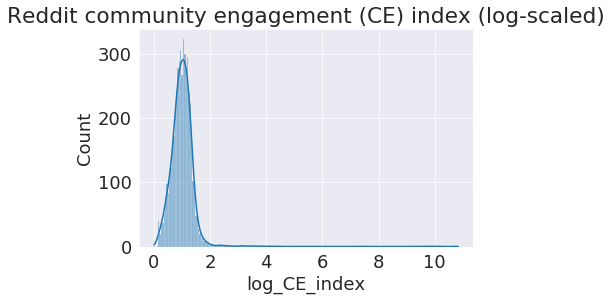

In [32]:
# Log-transformed CE index
log_CE_index = (np.log(df.score + 1) / np.log(df.num_comments + 1))
logCE_index_dist = log_CE_index.value_counts().rename_axis('log_CE_index').reset_index(name='counts')
sns.histplot(data=logCE_index_dist,
             x="log_CE_index",
             kde=True)
plt.title('Reddit community engagement (CE) index (log-scaled)')
plt.show()

This CE index looks much more functional.  We could standardize this data in some way, but we would lose qualitative data regarding the quality/type of engagement of a given post by doing so.  Ideally we want to keep the (y = x = 1 threshold).

## Temporal Data

Looking at a time series plot of submission counts, we observe more submissions tend to come in during Monday, Tuesday, and Wednesday, and weekends see the fewest submissions.

In [7]:
from datetime import date, timedelta
d0 = date(2020, 10, 1)
days_since_start = [(dt - d0).days for dt in df['date']]
df['days_since_start'] = days_since_start
day_counts = [sum([1 for i in df.days_since_start if i == j]) for j in range(365)]
days = [d0 + timedelta(days=i) for i in range(365)]

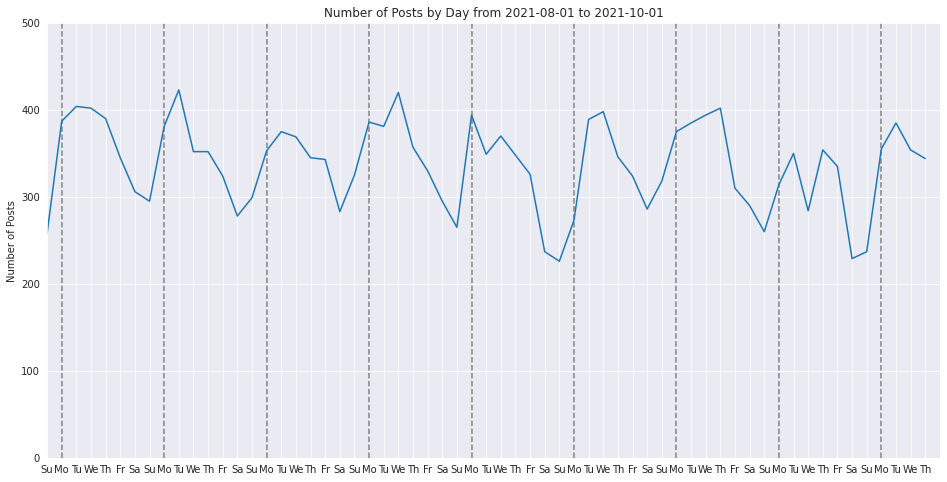

In [8]:
start_day = date(2021, 8, 1)
end_day = date(2021, 10, 1)
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hour = [dt.hour for dt in df['time']]
weekday = [dt.weekday() for dt in df['date']]
df['hour'] = hour
df['weekday'] = weekday
df['weekhour'] = df['hour'] + 24 * df['weekday']

plt.figure(figsize=(16,8))
plt.plot(days, day_counts)
plt.ylabel("Number of Posts")
plt.xlim(start_day, end_day)
plt.xticks([d0 + timedelta(days=i) for i in range((start_day-d0).days, (end_day-d0).days)], 
          labels = [weekdays[(d0 + timedelta(days=i)).weekday()][0:2] for i in range((start_day-d0).days,(end_day-d0).days)], fontsize=10)
plt.vlines([d0 + timedelta(days=i) for i in range((start_day-d0).days,(end_day-d0).days) if (d0 + timedelta(days=i)).weekday() ==0],
           0, 700, linestyles='dashed', color= 'grey')
plt.ylim(0,500)
plt.title("Number of Posts by Day from "+str(start_day)+" to "+ str(end_day))
plt.show()

This trend is cast in sharper relief when we look at the percentage of post submissions for each hour of the week. We can also subset our dataframe to only consider the posts with a score greater than 50, and plot the percentage of such posts for each hour of the week.

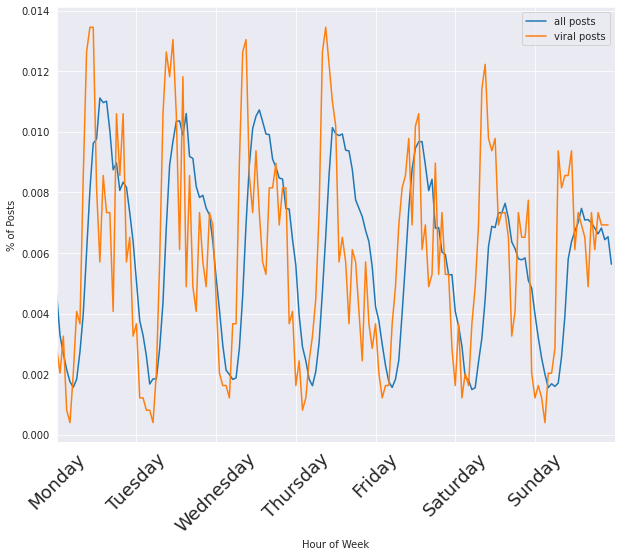

In [9]:
viral = df[df['score'] >= 50]

weekhour_counts = df.groupby('weekhour').count()['id'] / sum(df.groupby('weekhour').count()['id'])
weekhour_counts_viral = viral.groupby('weekhour').count()['id'] / sum(viral.groupby('weekhour').count()['id'])

plt.figure(figsize=(10,8))
plt.plot(range(len(weekhour_counts)), weekhour_counts, label='all posts')
plt.plot(range(len(weekhour_counts_viral)), weekhour_counts_viral, label='viral posts')
plt.xticks([h for h in range(0, 168, 24)], weekdays, fontsize=18, rotation=45)
plt.xlabel("Hour of Week")
plt.ylabel("% of Posts")
plt.xlim(0,168)
plt.legend()
plt.show()

The above plot also reveals seasonality within a given day. In particular, the early hours of the morning see the fewest posts. Then, the number of posts shoots up over the morning and reaches a peak in the early afternoon, and then tapers off gradually throughout the evening. 

We observe the daily seasonality of the subset of viral posts is a little different than the for all posts. In particular, posting in the morning (from 6 am to 10 am) seems to maximize the chances of going viral.

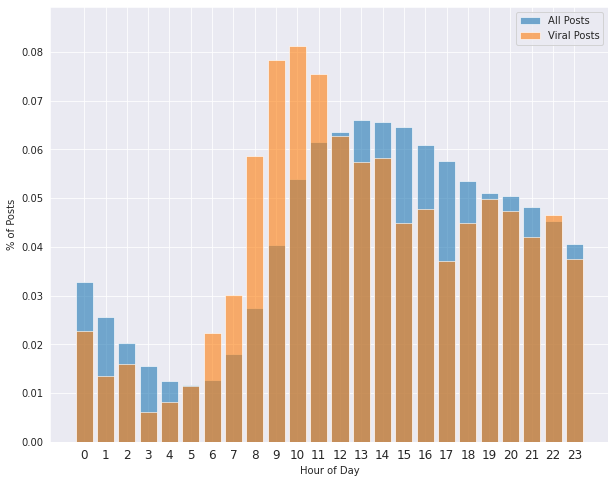

In [10]:
hourly_counts = df.groupby('hour').count()['id'] / sum(df.groupby('hour').count()['id'])
hourly_counts_viral = viral.groupby('hour').count()['id'] / sum(viral.groupby('hour').count()['id'])
plt.figure(figsize=(10,8))
plt.bar(range(len(hourly_counts)), hourly_counts, label='All Posts', alpha = 0.6)
plt.bar(range(len(hourly_counts_viral)), hourly_counts_viral, label='Viral Posts', alpha = 0.6)
plt.xticks([h for h in range(24)], [str(h) for h in range(24)], fontsize=12)
plt.xlabel("Hour of Day")
plt.ylabel("% of Posts")
plt.ylim(0, 1.1*max(hourly_counts_viral))
plt.legend()
plt.show()

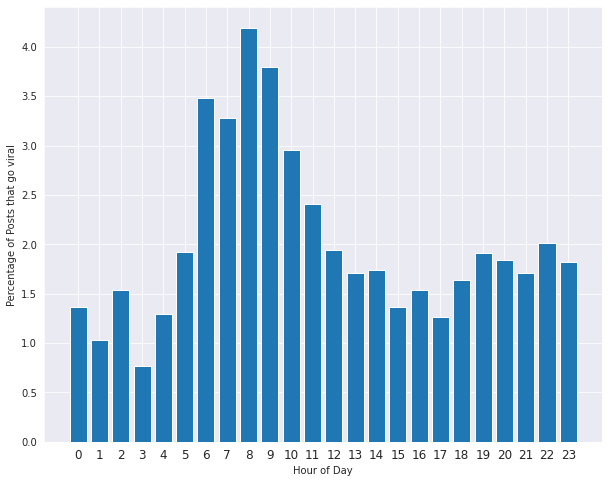

In [11]:
plt.figure(figsize=(10,8))
plt.bar(range(len(hourly_counts)), 100*viral.groupby('hour').count()['id'] / df.groupby('hour').count()['id'])
plt.xticks([h for h in range(24)], [str(h) for h in range(24)], fontsize=12)
plt.xlabel("Hour of Day")
plt.ylabel("Percentage of Posts that go viral")
plt.show()

## User Data

We then obtain post counts per user to obtain user engagement and plot them

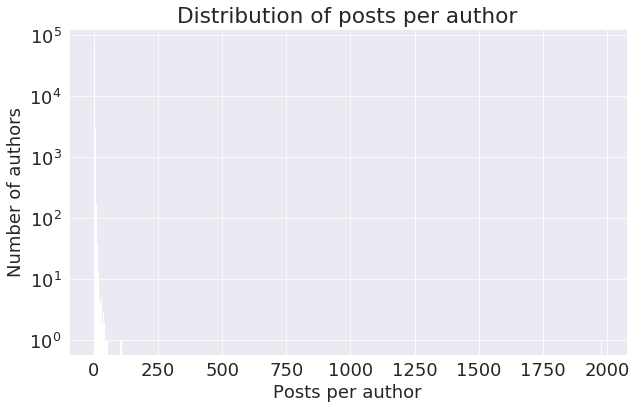

In [35]:
author_activity = df.author.value_counts().rename_axis('author').reset_index(name='posts')
auth_activity_binned = author_activity.posts.value_counts().rename_axis('posts_per_author').reset_index(name='number_of_authors')
plt.figure(figsize=(10,6))
plt.bar(auth_activity_binned.posts_per_author, auth_activity_binned.number_of_authors)

plt.title('Distribution of posts per author')
plt.xlabel('Posts per author')
plt.ylabel('Number of authors')

#plt.xscale('log')
plt.yscale('log')

plt.show()